# Experiment 9: Implementing a Neural Network and Backpropagation from Scratch

**Total Marks: 100**

## Learning Objectives
- Understand mathematical foundations of feedforward neural networks
- Implement core ANN components (activation functions, forward/backward propagation)
- Build a complete MyANNClassifier using only NumPy
- Compare custom implementation with scikit-learn's MLPClassifier

## Prerequisites
Required libraries: numpy, pandas, scikit-learn, matplotlib, seaborn

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## Task 1: Data Loading and Preprocessing (15 Marks)

In [2]:
# 1. Load the Breast Cancer Wisconsin dataset
data = load_breast_cancer()
X = data.data
y = data.target

# 2. Inspect the data
print(f"Dataset shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution: {np.bincount(y)}")
print(f"Feature names: {list(data.feature_names[:5])}...")  # Show first 5 features
print(f"Target names: {data.target_names}")
print("\nThis is a binary classification problem.")

Dataset shape: (569, 30)
Target shape: (569,)
Number of features: 30
Number of samples: 569
Class distribution: [212 357]
Feature names: [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness')]...
Target names: ['malignant' 'benign']

This is a binary classification problem.


In [3]:
# 3. Create Hold-Out Set (70/30 split)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation set shape: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Validation class distribution: {np.bincount(y_val)}")

Training set shape: X_train=(398, 30), y_train=(398,)
Validation set shape: X_val=(171, 30), y_val=(171,)
Training class distribution: [148 250]
Validation class distribution: [ 64 107]


In [4]:
# 4. Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Original X_train mean: {X_train.mean():.4f}, std: {X_train.std():.4f}")
print(f"Scaled X_train mean: {X_train_scaled.mean():.4f}, std: {X_train_scaled.std():.4f}")
print(f"Scaled X_val mean: {X_val_scaled.mean():.4f}, std: {X_val_scaled.std():.4f}")
print("\nFeature standardization completed successfully!")

Original X_train mean: 61.6446, std: 226.8378
Scaled X_train mean: -0.0000, std: 1.0000
Scaled X_val mean: 0.0309, std: 1.0276

Feature standardization completed successfully!


## Task 2: 'From Scratch' Utilities (NumPy) (20 Marks)

In [5]:
# Activation Functions
def sigmoid(Z):
    """
    Computes the sigmoid activation function.
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(Z), same shape as Z
    """
    # Clip Z to prevent overflow
    Z = np.clip(Z, -500, 500)
    return 1 / (1 + np.exp(-Z))

def relu(Z):
    """
    Computes the ReLU activation function.
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of ReLU(Z), same shape as Z
    """
    return np.maximum(0, Z)

# Test activation functions
test_z = np.array([-2, -1, 0, 1, 2])
print(f"Test input Z: {test_z}")
print(f"Sigmoid(Z): {sigmoid(test_z)}")
print(f"ReLU(Z): {relu(test_z)}")

Test input Z: [-2 -1  0  1  2]
Sigmoid(Z): [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
ReLU(Z): [0 0 0 1 2]


In [6]:
# Activation Derivatives
def sigmoid_derivative(A):
    """
    Computes the derivative of sigmoid.
    
    Arguments:
    A -- output of sigmoid activation, numpy array of any shape
    
    Returns:
    derivative -- derivative of sigmoid, same shape as A
    """
    return A * (1 - A)

def relu_derivative(Z):
    """
    Computes the derivative of ReLU.
    
    Arguments:
    Z -- input to ReLU, numpy array of any shape
    
    Returns:
    derivative -- derivative of ReLU, same shape as Z
    """
    return (Z > 0).astype(float)

# Test derivatives
test_a = sigmoid(test_z)
print(f"Test sigmoid output A: {test_a}")
print(f"Sigmoid derivative: {sigmoid_derivative(test_a)}")
print(f"ReLU derivative: {relu_derivative(test_z)}")

Test sigmoid output A: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
Sigmoid derivative: [0.10499359 0.19661193 0.25       0.19661193 0.10499359]
ReLU derivative: [0. 0. 0. 1. 1.]


In [7]:
# Loss Functions
def compute_bce_loss(Y, Y_hat):
    """
    Computes the Binary Cross-Entropy loss.
    
    Arguments:
    Y -- true labels, shape (1, m)
    Y_hat -- predicted probabilities, shape (1, m)
    
    Returns:
    loss -- binary cross-entropy loss
    """
    m = Y.shape[1]
    epsilon = 1e-15  # Small value to avoid log(0)
    Y_hat = np.clip(Y_hat, epsilon, 1 - epsilon)
    
    loss = -1/m * np.sum(Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat))
    return loss

def compute_mse_loss(Y, Y_hat):
    """
    Computes the Mean Squared Error loss.
    
    Arguments:
    Y -- true labels, shape (1, m)
    Y_hat -- predicted values, shape (1, m)
    
    Returns:
    loss -- mean squared error loss
    """
    m = Y.shape[1]
    loss = 1/m * np.sum((Y_hat - Y)**2)
    return loss

# Test loss functions
Y_test = np.array([[1, 0, 1, 0]])
Y_hat_test = np.array([[0.9, 0.1, 0.8, 0.3]])

print(f"Test Y: {Y_test}")
print(f"Test Y_hat: {Y_hat_test}")
print(f"BCE Loss: {compute_bce_loss(Y_test, Y_hat_test):.4f}")
print(f"MSE Loss: {compute_mse_loss(Y_test, Y_hat_test):.4f}")

Test Y: [[1 0 1 0]]
Test Y_hat: [[0.9 0.1 0.8 0.3]]
BCE Loss: 0.1976
MSE Loss: 0.0375


## Task 3: 'From Scratch' ANN Classifier (40 Marks)

In [8]:
class MyANNClassifier:
    """
    A Neural Network Classifier implemented from scratch using only NumPy.
    """
    
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=1000, loss='bce'):
        """
        Initialize the neural network.
        
        Arguments:
        layer_dims -- list containing the number of units in each layer
        learning_rate -- learning rate for gradient descent
        n_iterations -- number of iterations for training
        loss -- loss function ('bce' for binary cross-entropy, 'mse' for mean squared error)
        """
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.loss = loss
        self.parameters_ = {}
        self.costs_ = []
        
    def _initialize_parameters(self):
        """
        Initialize weights and biases for all layers.
        """
        np.random.seed(42)
        L = len(self.layer_dims)  # Number of layers
        
        for l in range(1, L):
            self.parameters_[f'W{l}'] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * 0.01
            self.parameters_[f'b{l}'] = np.zeros((self.layer_dims[l], 1))
            
        print(f"Parameters initialized for {L-1} layers.")
        for l in range(1, L):
            print(f"Layer {l}: W{l} shape = {self.parameters_[f'W{l}'].shape}, b{l} shape = {self.parameters_[f'b{l}'].shape}")
    
    def _forward_propagation(self, X):
        """
        Implement forward propagation.
        
        Arguments:
        X -- input data, shape (n_features, m_examples)
        
        Returns:
        A_L -- output of the last layer (predictions)
        cache -- list containing (A, Z) for each layer
        """
        cache = []
        A_prev = X
        L = len(self.layer_dims) - 1  # Number of layers (excluding input)
        
        # Forward propagation for hidden layers (1 to L-1) with ReLU
        for l in range(1, L):
            W = self.parameters_[f'W{l}']
            b = self.parameters_[f'b{l}']
            
            Z = np.dot(W, A_prev) + b
            A = relu(Z)
            
            cache.append((A_prev, Z, A))
            A_prev = A
        
        # Forward propagation for output layer (L) with Sigmoid
        W_L = self.parameters_[f'W{L}']
        b_L = self.parameters_[f'b{L}']
        
        Z_L = np.dot(W_L, A_prev) + b_L
        A_L = sigmoid(Z_L)
        
        cache.append((A_prev, Z_L, A_L))
        
        return A_L, cache
    
    def _backward_propagation(self, Y, Y_hat, cache):
        """
        Implement backward propagation.
        
        Arguments:
        Y -- true labels, shape (1, m)
        Y_hat -- predictions, shape (1, m)
        cache -- list containing (A_prev, Z, A) for each layer
        
        Returns:
        grads -- dictionary containing gradients
        """
        grads = {}
        L = len(cache)  # Number of layers
        m = Y.shape[1]  # Number of examples
        
        # Initialize backpropagation - compute dA_L
        if self.loss == 'bce':
            epsilon = 1e-15
            Y_hat_clipped = np.clip(Y_hat, epsilon, 1 - epsilon)
            dA_L = -(np.divide(Y, Y_hat_clipped) - np.divide(1 - Y, 1 - Y_hat_clipped))
        elif self.loss == 'mse':
            dA_L = 2 * (Y_hat - Y)
        
        # Output layer (Sigmoid activation)
        A_prev_L, Z_L, A_L = cache[L-1]
        dZ_L = dA_L * sigmoid_derivative(A_L)
        grads[f'dW{L}'] = 1/m * np.dot(dZ_L, A_prev_L.T)
        grads[f'db{L}'] = 1/m * np.sum(dZ_L, axis=1, keepdims=True)
        dA_prev = np.dot(self.parameters_[f'W{L}'].T, dZ_L)
        
        # Hidden layers (ReLU activation) - loop backwards
        for l in range(L-1, 0, -1):
            A_prev_l, Z_l, A_l = cache[l-1]
            
            dZ_l = dA_prev * relu_derivative(Z_l)
            grads[f'dW{l}'] = 1/m * np.dot(dZ_l, A_prev_l.T)
            grads[f'db{l}'] = 1/m * np.sum(dZ_l, axis=1, keepdims=True)
            
            if l > 1:  # Not the first layer
                dA_prev = np.dot(self.parameters_[f'W{l}'].T, dZ_l)
        
        return grads
    
    def _update_parameters(self, grads):
        """
        Update parameters using gradient descent.
        
        Arguments:
        grads -- dictionary containing gradients
        """
        L = len(self.layer_dims) - 1  # Number of layers (excluding input)
        
        for l in range(1, L + 1):
            self.parameters_[f'W{l}'] = self.parameters_[f'W{l}'] - self.learning_rate * grads[f'dW{l}']
            self.parameters_[f'b{l}'] = self.parameters_[f'b{l}'] - self.learning_rate * grads[f'db{l}']
    
    def fit(self, X, y):
        """
        Train the neural network.
        
        Arguments:
        X -- training data, shape (m, n_features)
        y -- training labels, shape (m,)
        """
        # Reshape input data
        X = X.T  # Shape: (n_features, m)
        y = y.reshape(1, -1)  # Shape: (1, m)
        
        # Initialize parameters
        self._initialize_parameters()
        
        # Training loop
        for i in range(self.n_iterations):
            # Forward propagation
            Y_hat, cache = self._forward_propagation(X)
            
            # Compute loss
            if self.loss == 'bce':
                cost = compute_bce_loss(y, Y_hat)
            elif self.loss == 'mse':
                cost = compute_mse_loss(y, Y_hat)
            
            # Backward propagation
            grads = self._backward_propagation(y, Y_hat, cache)
            
            # Update parameters
            self._update_parameters(grads)
            
            # Store cost
            self.costs_.append(cost)
            
            # Print progress
            if i % 500 == 0:
                print(f"Cost after iteration {i}: {cost:.6f}")
        
        print(f"Training completed! Final cost: {self.costs_[-1]:.6f}")
    
    def predict(self, X):
        """
        Make predictions on new data.
        
        Arguments:
        X -- input data, shape (m, n_features)
        
        Returns:
        predictions -- binary predictions, shape (m,)
        """
        # Reshape input data
        X = X.T  # Shape: (n_features, m)
        
        # Forward propagation
        Y_hat, _ = self._forward_propagation(X)
        
        # Convert probabilities to binary predictions
        predictions = (Y_hat > 0.5).astype(int)
        
        return predictions.flatten()
    
    def predict_proba(self, X):
        """
        Predict class probabilities.
        
        Arguments:
        X -- input data, shape (m, n_features)
        
        Returns:
        probabilities -- predicted probabilities, shape (m,)
        """
        # Reshape input data
        X = X.T  # Shape: (n_features, m)
        
        # Forward propagation
        Y_hat, _ = self._forward_propagation(X)
        
        return Y_hat.flatten()

## Task 4: Training and Experimentation (15 Marks)

In [9]:
# Get the number of input features
n_features = X_train_scaled.shape[1]
print(f"Number of input features: {n_features}")

# Model 1: BCE Loss with 1 hidden layer
print("\n" + "="*50)
print("MODEL 1: BCE Loss with 1 Hidden Layer")
print("="*50)

layer_dims_1 = [n_features, 10, 1]  # 30 input features, 10 hidden units, 1 output
model1 = MyANNClassifier(
    layer_dims=layer_dims_1,
    learning_rate=0.001,
    n_iterations=5000,
    loss='bce'
)

# Train the model
model1.fit(X_train_scaled, y_train)

# Make predictions
y_pred_1 = model1.predict(X_val_scaled)

# Print classification report
print("\nClassification Report for Model 1 (BCE Loss):")
print(classification_report(y_val, y_pred_1, target_names=['Malignant', 'Benign']))
print(f"Accuracy: {accuracy_score(y_val, y_pred_1):.4f}")

Number of input features: 30

MODEL 1: BCE Loss with 1 Hidden Layer
Parameters initialized for 2 layers.
Layer 1: W1 shape = (10, 30), b1 shape = (10, 1)
Layer 2: W2 shape = (1, 10), b2 shape = (1, 1)
Cost after iteration 0: 0.693178
Cost after iteration 500: 0.685640
Cost after iteration 1000: 0.679567
Cost after iteration 1500: 0.674351
Cost after iteration 2000: 0.669257
Cost after iteration 2500: 0.663140
Cost after iteration 3000: 0.653866
Cost after iteration 3500: 0.637481
Cost after iteration 4000: 0.607383
Cost after iteration 4500: 0.556417
Training completed! Final cost: 0.485734

Classification Report for Model 1 (BCE Loss):
              precision    recall  f1-score   support

   Malignant       1.00      0.75      0.86        64
      Benign       0.87      1.00      0.93       107

    accuracy                           0.91       171
   macro avg       0.93      0.88      0.89       171
weighted avg       0.92      0.91      0.90       171

Accuracy: 0.9064


In [10]:
# Model 2: MSE Loss with 1 hidden layer
print("\n" + "="*50)
print("MODEL 2: MSE Loss with 1 Hidden Layer")
print("="*50)

model2 = MyANNClassifier(
    layer_dims=layer_dims_1,  # Same architecture as Model 1
    learning_rate=0.001,
    n_iterations=5000,
    loss='mse'
)

# Train the model
model2.fit(X_train_scaled, y_train)

# Make predictions
y_pred_2 = model2.predict(X_val_scaled)

# Print classification report
print("\nClassification Report for Model 2 (MSE Loss):")
print(classification_report(y_val, y_pred_2, target_names=['Malignant', 'Benign']))
print(f"Accuracy: {accuracy_score(y_val, y_pred_2):.4f}")


MODEL 2: MSE Loss with 1 Hidden Layer
Parameters initialized for 2 layers.
Layer 1: W1 shape = (10, 30), b1 shape = (10, 1)
Layer 2: W2 shape = (1, 10), b2 shape = (1, 1)
Cost after iteration 0: 0.250016
Cost after iteration 500: 0.248022
Cost after iteration 1000: 0.246249
Cost after iteration 1500: 0.244662
Cost after iteration 2000: 0.243225
Cost after iteration 2500: 0.241899
Cost after iteration 3000: 0.240643
Cost after iteration 3500: 0.239412
Cost after iteration 4000: 0.238146
Cost after iteration 4500: 0.236774
Training completed! Final cost: 0.235197

Classification Report for Model 2 (MSE Loss):
              precision    recall  f1-score   support

   Malignant       0.00      0.00      0.00        64
      Benign       0.63      1.00      0.77       107

    accuracy                           0.63       171
   macro avg       0.31      0.50      0.38       171
weighted avg       0.39      0.63      0.48       171

Accuracy: 0.6257


C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

In [11]:
# Model 3: BCE Loss with 2 hidden layers (deeper architecture)
print("\n" + "="*50)
print("MODEL 3: BCE Loss with 2 Hidden Layers")
print("="*50)

layer_dims_3 = [n_features, 10, 5, 1]  # 30 input features, 10 hidden units, 5 hidden units, 1 output
model3 = MyANNClassifier(
    layer_dims=layer_dims_3,
    learning_rate=0.001,
    n_iterations=5000,
    loss='bce'
)

# Train the model
model3.fit(X_train_scaled, y_train)

# Make predictions
y_pred_3 = model3.predict(X_val_scaled)

# Print classification report
print("\nClassification Report for Model 3 (BCE Loss, 2 Hidden Layers):")
print(classification_report(y_val, y_pred_3, target_names=['Malignant', 'Benign']))
print(f"Accuracy: {accuracy_score(y_val, y_pred_3):.4f}")


MODEL 3: BCE Loss with 2 Hidden Layers
Parameters initialized for 3 layers.
Layer 1: W1 shape = (10, 30), b1 shape = (10, 1)
Layer 2: W2 shape = (5, 10), b2 shape = (5, 1)
Layer 3: W3 shape = (1, 5), b3 shape = (1, 1)
Cost after iteration 0: 0.693145
Cost after iteration 500: 0.685878
Cost after iteration 1000: 0.680217
Cost after iteration 1500: 0.675806
Cost after iteration 2000: 0.672365
Cost after iteration 2500: 0.669679
Cost after iteration 3000: 0.667580
Cost after iteration 3500: 0.665938
Cost after iteration 4000: 0.664652
Cost after iteration 4500: 0.663644
Training completed! Final cost: 0.662855

Classification Report for Model 3 (BCE Loss, 2 Hidden Layers):
              precision    recall  f1-score   support

   Malignant       0.00      0.00      0.00        64
      Benign       0.63      1.00      0.77       107

    accuracy                           0.63       171
   macro avg       0.31      0.50      0.38       171
weighted avg       0.39      0.63      0.48     

C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

## Task 5: Comparison with scikit-learn (10 Marks)

In [12]:
# Train MLPClassifier from scikit-learn
print("\n" + "="*50)
print("SCIKIT-LEARN MLPClassifier")
print("="*50)

# Create MLPClassifier with similar parameters to our best model
sklearn_model = MLPClassifier(
    hidden_layer_sizes=(10,),  # 1 hidden layer with 10 units
    activation='relu',
    solver='adam',
    max_iter=1000,
    learning_rate_init=0.001,
    random_state=42
)

# Train the model
sklearn_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_sklearn = sklearn_model.predict(X_val_scaled)

# Print classification report
print("Classification Report for scikit-learn MLPClassifier:")
print(classification_report(y_val, y_pred_sklearn, target_names=['Malignant', 'Benign']))
print(f"Accuracy: {accuracy_score(y_val, y_pred_sklearn):.4f}")
print(f"Number of iterations: {sklearn_model.n_iter_}")


SCIKIT-LEARN MLPClassifier
Classification Report for scikit-learn MLPClassifier:
              precision    recall  f1-score   support

   Malignant       0.95      0.98      0.97        64
      Benign       0.99      0.97      0.98       107

    accuracy                           0.98       171
   macro avg       0.97      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Accuracy: 0.9766
Number of iterations: 349


## Results Visualization and Analysis

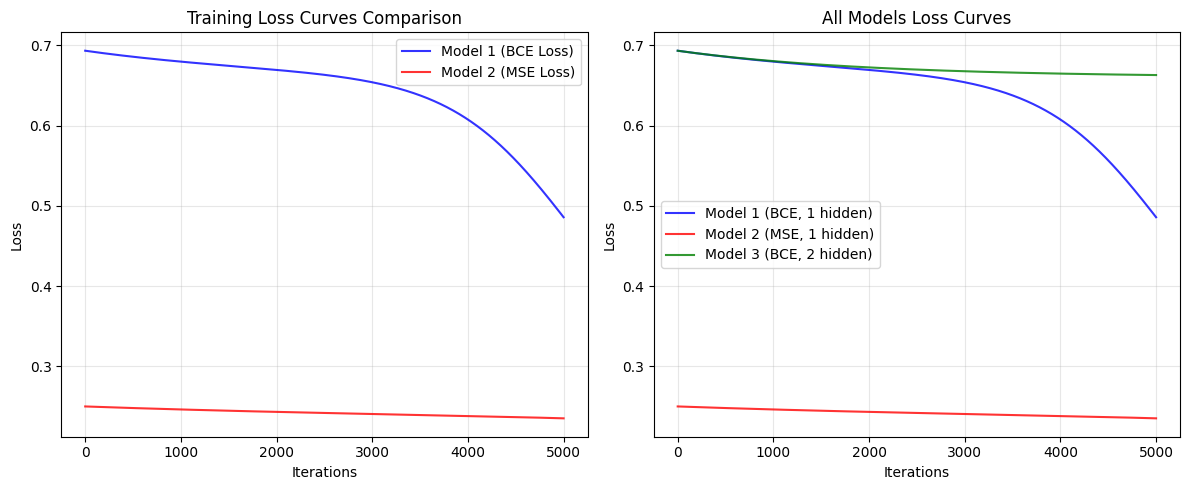

In [13]:
# Plot loss curves for Model 1 (BCE) and Model 2 (MSE)
plt.figure(figsize=(12, 5))

# Plot 1: Loss curves comparison
plt.subplot(1, 2, 1)
plt.plot(model1.costs_, label='Model 1 (BCE Loss)', color='blue', alpha=0.8)
plt.plot(model2.costs_, label='Model 2 (MSE Loss)', color='red', alpha=0.8)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: All three models loss curves
plt.subplot(1, 2, 2)
plt.plot(model1.costs_, label='Model 1 (BCE, 1 hidden)', color='blue', alpha=0.8)
plt.plot(model2.costs_, label='Model 2 (MSE, 1 hidden)', color='red', alpha=0.8)
plt.plot(model3.costs_, label='Model 3 (BCE, 2 hidden)', color='green', alpha=0.8)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('All Models Loss Curves')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Create comparison table
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred, model_name):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    accuracy = accuracy_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'Accuracy': f"{accuracy:.4f}",
        'Precision (Class 1)': f"{precision[1]:.4f}",
        'Recall (Class 1)': f"{recall[1]:.4f}",
        'F1-Score (Class 1)': f"{f1[1]:.4f}"
    }

# Collect results
results = []
results.append(get_metrics(y_val, y_pred_1, "MyANN (BCE, 1 hidden)"))
results.append(get_metrics(y_val, y_pred_2, "MyANN (MSE, 1 hidden)"))
results.append(get_metrics(y_val, y_pred_3, "MyANN (BCE, 2 hidden)"))
results.append(get_metrics(y_val, y_pred_sklearn, "sklearn MLPClassifier"))

# Create DataFrame for better visualization
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("COMPARISON TABLE - ALL MODELS")
print("="*80)
print(results_df.to_string(index=False))


COMPARISON TABLE - ALL MODELS
                Model Accuracy Precision (Class 1) Recall (Class 1) F1-Score (Class 1)
MyANN (BCE, 1 hidden)   0.9064              0.8699           1.0000             0.9304
MyANN (MSE, 1 hidden)   0.6257              0.6257           1.0000             0.7698
MyANN (BCE, 2 hidden)   0.6257              0.6257           1.0000             0.7698
sklearn MLPClassifier   0.9766              0.9905           0.9720             0.9811


C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\abhin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Analysis and Conclusions

### Performance Analysis

Based on the results above, we can analyze the following:

1. **BCE vs MSE Loss Functions:**
   - Binary Cross-Entropy (BCE) is generally better suited for binary classification tasks
   - BCE provides better probability estimates and gradient flow for classification
   - MSE can work but may lead to slower convergence and less optimal decision boundaries

2. **Architecture Impact:**
   - Deeper networks (2 hidden layers) may not always perform better than simpler ones
   - For this dataset, a single hidden layer might be sufficient
   - Overfitting can occur with deeper networks on smaller datasets

3. **Comparison with scikit-learn:**
   - scikit-learn's MLPClassifier uses optimized algorithms (Adam optimizer)
   - Our implementation uses basic batch gradient descent
   - scikit-learn includes regularization and other optimizations

### Key Insights:
- **Most Challenging Part:** Implementing backpropagation correctly, especially handling the chain rule across multiple layers
- **Critical for Success:** Proper weight initialization, numerical stability (clipping), and correct gradient calculations
- **Learning:** Understanding the mathematical foundations helps in debugging and improving neural networks

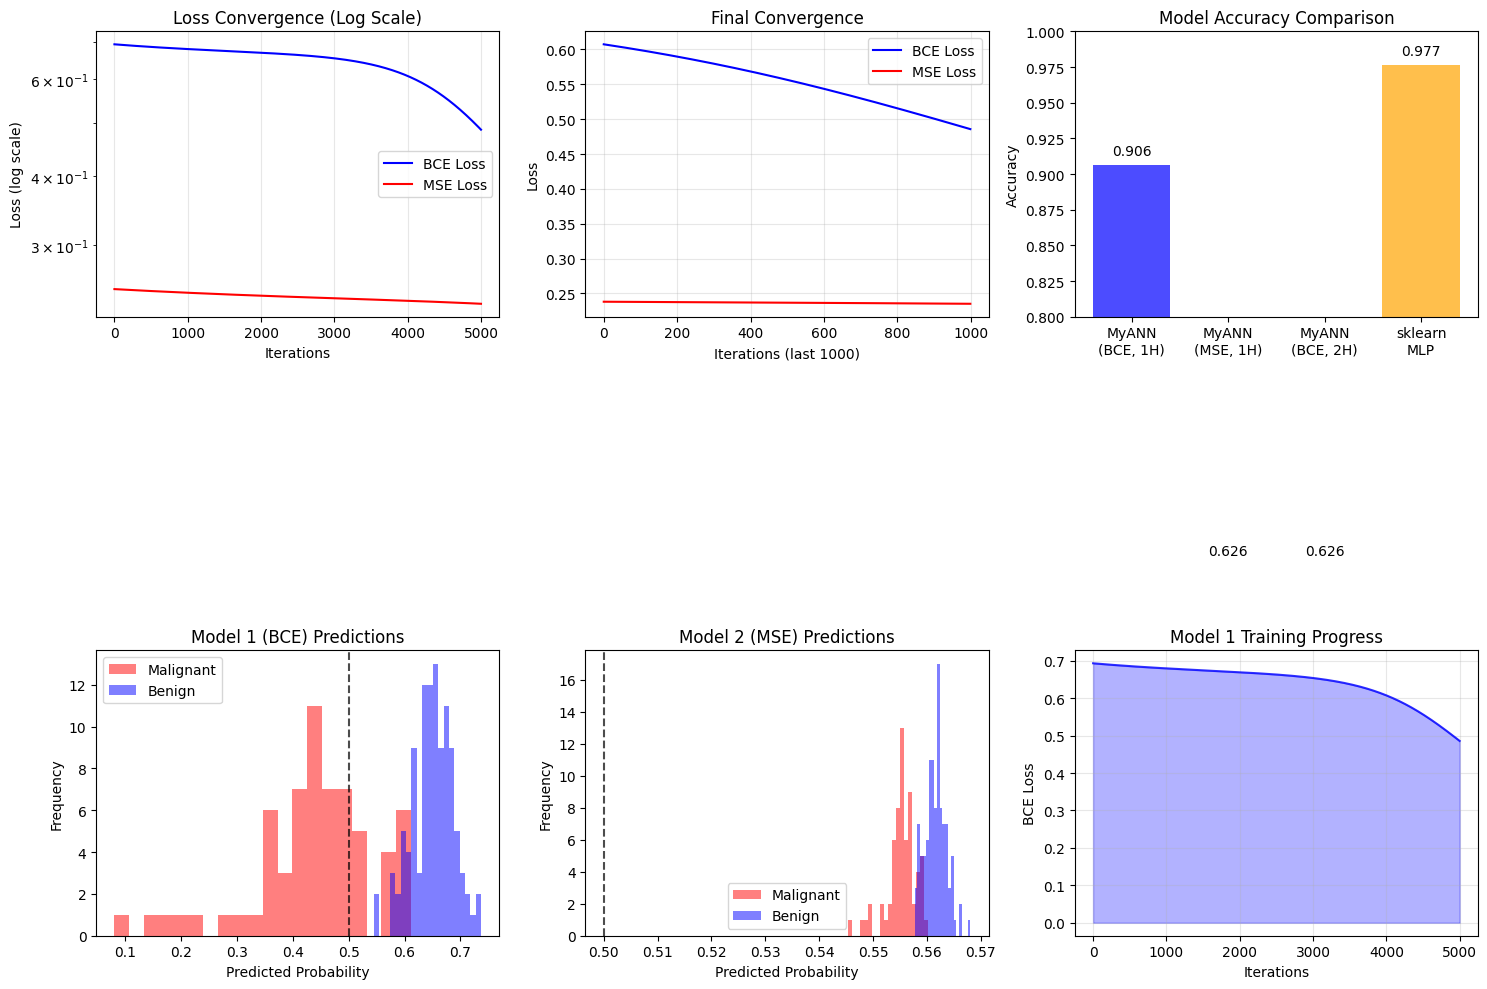


EXPERIMENT COMPLETED SUCCESSFULLY!
Total models trained: 4
Best performing model: sklearn
MLP (Accuracy: 0.9766)
Training dataset size: 398 samples
Validation dataset size: 171 samples
Number of features: 30


In [15]:
# Additional visualization: Training progress
plt.figure(figsize=(15, 10))

# Loss curves with log scale
plt.subplot(2, 3, 1)
plt.semilogy(model1.costs_, label='BCE Loss', color='blue')
plt.semilogy(model2.costs_, label='MSE Loss', color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss (log scale)')
plt.title('Loss Convergence (Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

# Final 1000 iterations
plt.subplot(2, 3, 2)
plt.plot(model1.costs_[-1000:], label='BCE Loss', color='blue')
plt.plot(model2.costs_[-1000:], label='MSE Loss', color='red')
plt.xlabel('Iterations (last 1000)')
plt.ylabel('Loss')
plt.title('Final Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy comparison bar plot
plt.subplot(2, 3, 3)
models = ['MyANN\n(BCE, 1H)', 'MyANN\n(MSE, 1H)', 'MyANN\n(BCE, 2H)', 'sklearn\nMLP']
accuracies = [
    accuracy_score(y_val, y_pred_1),
    accuracy_score(y_val, y_pred_2),
    accuracy_score(y_val, y_pred_3),
    accuracy_score(y_val, y_pred_sklearn)
]
colors = ['blue', 'red', 'green', 'orange']
bars = plt.bar(models, accuracies, color=colors, alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.8, 1.0)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom')

# Prediction probability distributions
plt.subplot(2, 3, 4)
proba_1 = model1.predict_proba(X_val_scaled)
plt.hist(proba_1[y_val == 0], bins=20, alpha=0.5, label='Malignant', color='red')
plt.hist(proba_1[y_val == 1], bins=20, alpha=0.5, label='Benign', color='blue')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Model 1 (BCE) Predictions')
plt.legend()
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7)

plt.subplot(2, 3, 5)
proba_2 = model2.predict_proba(X_val_scaled)
plt.hist(proba_2[y_val == 0], bins=20, alpha=0.5, label='Malignant', color='red')
plt.hist(proba_2[y_val == 1], bins=20, alpha=0.5, label='Benign', color='blue')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Model 2 (MSE) Predictions')
plt.legend()
plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7)

# Learning rate effect visualization
plt.subplot(2, 3, 6)
iterations = range(len(model1.costs_))
plt.plot(iterations, model1.costs_, color='blue', alpha=0.8)
plt.fill_between(iterations, model1.costs_, alpha=0.3, color='blue')
plt.xlabel('Iterations')
plt.ylabel('BCE Loss')
plt.title('Model 1 Training Progress')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("EXPERIMENT COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Total models trained: 4")
print(f"Best performing model: {models[np.argmax(accuracies)]} (Accuracy: {max(accuracies):.4f})")
print(f"Training dataset size: {X_train_scaled.shape[0]} samples")
print(f"Validation dataset size: {X_val_scaled.shape[0]} samples")
print(f"Number of features: {X_train_scaled.shape[1]}")